In [1]:
import cobra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio import SeqIO
import xlrd

In [2]:
def get_protein_mw(infile):
    mws = {} # {protein_id: Da}
    for rec in SeqIO.parse(open(infile),'fasta'):
        seq = str(rec.seq)
        seq = seq.replace('*','')
        pa = ProteinAnalysis(seq)
        
        mws[rec.id] = pa.molecular_weight()
        
    print(len(mws))
    return mws

In [3]:
def load_met_enzymes(modelfile):
    model = cobra.io.load_json_model(modelfile)
    is_metabolic_gene = {gene.id:True for gene in model.genes}
    return is_metabolic_gene

In [4]:
def calculate_total_measured(df,mws):
    Pm = dict()
    for col in df.columns:
        for protein in df.index:
            pab = df.loc[protein,col]
            if np.isnan(pab): continue   
            Pm[col] = Pm.get(col,0) + pab*mws[protein]*1e-3
    return Pm

In [5]:
def calculate_enzyme_measured(df,mws,is_metabolic_gene):
    Pm = dict()
    for col in df.columns:
        for protein in df.index:
            if not is_metabolic_gene.get(protein,False): continue
            pab = df.loc[protein,col]
            if np.isnan(pab): continue   
            Pm[col] = Pm.get(col,0) + pab*mws[protein]*1e-3
    return Pm

In [6]:
def plot_log_transformed_abandance(df,figsize=None):
    dflog = df.copy()
    for col in dflog.columns: dflog[col] = np.log10(dflog[col].values)
    dflog.hist(bins=20,figsize=figsize)
    plt.tight_layout()
    plt.show()

In [11]:
modelfile = '../../../ModelFiles/json/Halo_GEM_v1.json'
protein_ab_file = '../proteomics/protein_abandance.csv'
protein_seq_file = '../../../ComplementaryData/protein_sequences_v3.0.fasta'

#### 1. look at the total measured protein amount
* protein abandance (pab) is in the unit of mmol/gDW
* mw: g/mol  
* 1e-3 x pab x mw = g/gDw

In [8]:
mws = get_protein_mw(protein_seq_file)

3927


In [9]:
fhand = open('../Results/protein_mws.csv','w')
fhand.write('ID,MW\n')
for k,v in mws.items(): fhand.write('{0},{1}\n'.format(k,v))
fhand.close()

In [12]:
df = pd.read_csv(protein_ab_file,index_col=0)
Pm = calculate_total_measured(df,mws)

In [13]:
Pm

{'NACL60': 0.16479422582096273,
 'NACL20': 0.049594525304013065,
 'NACL100': 0.04175929307813453,
 'HN': 0.1650430025074488,
 'MU': 0.020083409599586016}

In [14]:
a = set()

In [16]:
a.add('a')

In [17]:
a

{'a'}

In [18]:
a.add('a')
a

{'a'}

### Yeast data
protein seq data was downloaded from http://sgd-archive.yeastgenome.org/sequence/S288C_reference/orf_protein/orf_trans_all.fasta.gz


proteomics data was from Petri

In [12]:
def load_yeast_protemics():
    book = xlrd.open_workbook('../YeastData/SI_Tables.xlsx')
    sh = book.sheet_by_name('SI_Table3')
    df = pd.DataFrame()
    for i in range(sh.nrows):
        if i<4: continue
        seq_id = sh.cell(i,0).value
        for j in range(10):
            col = sh.cell(2,j+1).value
            num = sh.cell(i,j+1).value
            if str(num) == 'NA': num = np.nan
            df.loc[seq_id,col] = num*10**3/6.02/1e23/1e-12
    print(df.shape)
    return df

In [13]:
dfyeast = load_yeast_protemics()

(2139, 10)


In [14]:
mws_yeast = get_protein_mw('../YeastData/orf_trans_all.fasta')

In [15]:
Pm_yeast =  calculate_total_measured(dfyeast,mws_yeast)

In [16]:
Pm_yeast

{'REF': 0.47870160138276774,
 'EtOH  20g/L': 0.4705435667157299,
 'EtOH  40g/L': 0.45679541145301883,
 'EtOH  60g/L': 0.4310456249670661,
 'Osmo 0.2 M (NaCl)': 0.5016325569122959,
 'Osmo 0.4 M (NaCl)': 0.4989402887269554,
 'Osmo 0.6 M (NaCl)': 0.5057316457004101,
 'Temp 33C': 0.4967188963363541,
 'Temp 36C': 0.495122242543668,
 'Temp 38C': 0.4505315425126893}

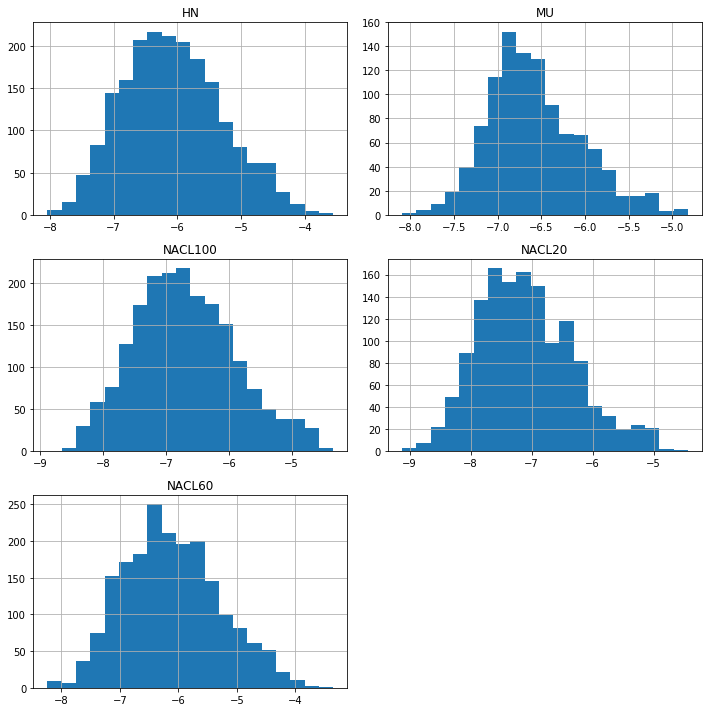

In [17]:
plot_log_transformed_abandance(df,figsize=(10,10))

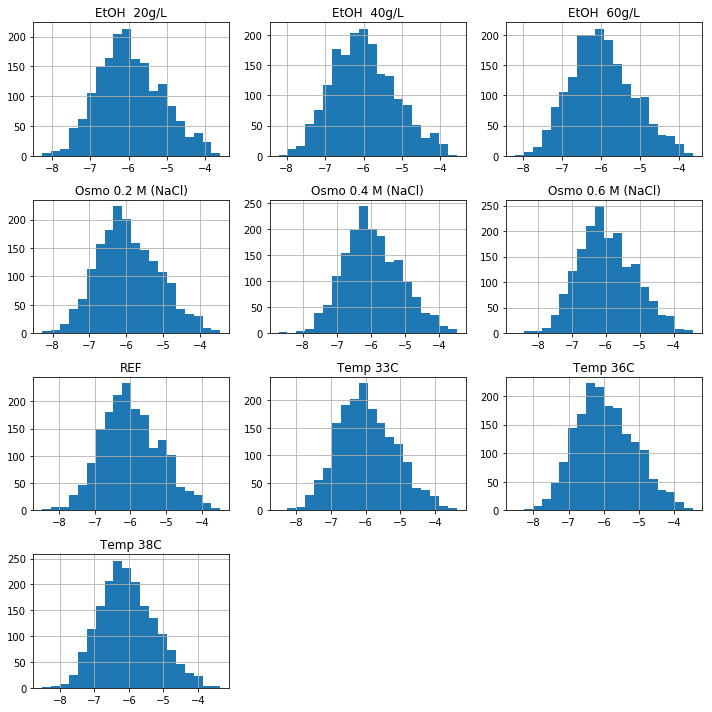

In [18]:
plot_log_transformed_abandance(dfyeast,figsize=(10,10))

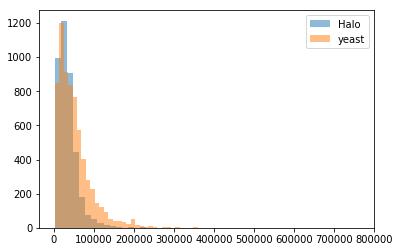

In [19]:
plt.hist(mws.values(),label='Halo',bins=50,alpha=0.5)
plt.hist(mws_yeast.values(),label='yeast',bins=50,alpha=0.5)
plt.legend()
plt.show()

#### percentage of enzymes

In [22]:
Pmenzyme = calculate_enzyme_measured(df,mws,load_met_enzymes(modelfile))

Using license file /Users/gangl/gurobi.lic
Academic license - for non-commercial use only


In [23]:
Pmenzyme

{'NACL60': 0.1304131943095682,
 'NACL20': 0.007574482763001577,
 'NACL100': 0.035263241852085674,
 'HN': 0.13061214457348444,
 'MU': 0.010759811390797652}

In [24]:
Pm

{'NACL60': 0.2617338227689495,
 'NACL20': 0.02010555409726972,
 'NACL100': 0.06915325405426205,
 'HN': 0.25630349262794194,
 'MU': 0.020083409599586016}